In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
import god_config as config
dir_path = os.getcwd()

In [2]:
#Load the data
# roi = 'VC'
# X = np.load(dir_path+'/data/Subject1_'+roi+'_fmri.npy')
# datatype=np.load(dir_path+'/data/Subject1_datatype.npy')
X = np.load(dir_path+'/padded_data/VC.npy')
datatype = np.load(dir_path+'/padded_data/datatype.npy')
y = np.zeros((len(datatype),))
y[np.where(datatype == 3)[0]] = 1

print (X.shape)
print (y.shape)
print (len(y[y == 0]))
print (len(y[y == 1]))

(17250, 45, 29, 22)
(17250,)
14750
2500


In [3]:
def make_into_dataloader(X,y, batch_size):
    newX = torch.Tensor(X).unsqueeze_(1)
    newy = torch.LongTensor(y)
    dataset = data_utils.TensorDataset(newX,newy)
    dataloader = data_utils.DataLoader(dataset,
                                      batch_size = batch_size,
                                      num_workers = 0,
                                      shuffle = True)
    return dataloader

In [4]:
#Define the convolutional neural network model
#Note: Each fmri scan is of size 45 x 29 x 22
class fmriNet(nn.Module):
    def __init__(self):
        super(fmriNet, self).__init__()
        #conv1, conv2, and conv3 maintain input dimensions
        self.conv1 = nn.Sequential(
            nn.Conv3d(1, 8, 3, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU())
        self.conv2 = nn.Sequential(
            nn.Conv3d(8, 8, 3, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU())
        self.conv3 = nn.Sequential(
            nn.Conv3d(8, 8, 3, padding = 1),
            nn.BatchNorm3d(8),
            nn.ReLU())
        #conv4 changes data to object of size 20 x 13 x 9
        self.conv4 = nn.Sequential(
            nn.Conv3d(8, 16, (7,5,4), stride = (2,2,2)),
            nn.BatchNorm3d(16),
            nn.ReLU())
        
        #conv5, conv6, and conv7 maintain dimensions 20 x 13 x 9
        self.conv5 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU())
        self.conv6 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU())
        self.conv7 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding = 1),
            nn.BatchNorm3d(16),
            nn.ReLU())
        
        #conv8 changes data to object of size 7 x 5 x 4
        self.conv8 = nn.Sequential(
            nn.Conv3d(16, 32, (8,5,3), stride = (2,2,2)),
            nn.BatchNorm3d(32),
            nn.ReLU())
        
        #conv9, conv10, and conv11 maintain dimensions 7 x 5 x 4
        self.conv9 = nn.Sequential(
            nn.Conv3d(32, 32, 3, padding = 1),
            nn.BatchNorm3d(32),
            nn.ReLU())
        self.conv10 = nn.Sequential(
            nn.Conv3d(32, 32, 3, padding = 1),
            nn.BatchNorm3d(32),
            nn.ReLU())
        self.conv11 = nn.Sequential(
            nn.Conv3d(32, 32, 3, padding = 1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout(0.5))
        
        #Flatten to vector of length 32 x 7 x 5 x 4 = 4480
        #Fully connected layer from 4480 to 100
        self.fc1 = nn.Sequential(
            nn.Linear(4480, 1000),
            nn.ReLU(),
            nn.Dropout(0.5))
        #Fully connected layer from 100 to 10
        self.fc2 = nn.Sequential(
            nn.Linear(1000,100),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc3 = nn.Sequential(
            nn.Linear(100,10),
            nn.ReLU(),
            nn.Dropout(0.5))
        #Fully connected layer from 10 to 2, being the two outputs
        self.fcout = nn.Linear(10,2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.conv9(out)
        out = self.conv10(out)
        out = self.conv11(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fcout(out)
        return out

In [5]:
#Function to test the model
def test(model, data_loader):
    print ("Testing Accuracy...")
    total_items = 0
    total_steps = len(data_loader)
    correct = 0
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(data_loader):
            #move data to gpu
            fmris = sample[0].to(device)
            labels = sample[1].to(device)
            total_items += len(labels)
            
            #feed data forward
            outputs = model(fmris)

            _, predicted = torch.max(outputs, 1)
            correct += torch.sum(predicted == labels).item()
            #print ("Step [{}/{}]".format(i+1, total_steps, end = "\r"))
                   
    acc = correct/total_items
    print ("Accuracy: {:.2f}% [{}/{}]".format(acc*100, correct,total_items))
    return acc
    
#Function to perform k-fold cross validation on the model
def train(model, train_loader, num_epochs, criterion, optimizer, losses = []):
    model.train()
    losses = losses
    steps_per_epoch = len(train_loader)
    for i in range(num_epochs):
        for j, sample in enumerate(train_loader):
            #move data to gpu
            fmris = sample[0].to(device)
            labels = sample[1].to(device)

            #feed data forward
            outputs = model(fmris)
            loss = criterion(outputs, labels)
            losses.append(loss)

            #backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print ("Training Epoch: [{}/{}]\tStep: [{}/{}]\tLoss:{:.10f}".format(i+1,num_epochs,j+1,steps_per_epoch, loss), end = "\r")
    return losses

In [ ]:
#hyperparameters
learning_rate = 0.0001
batch_size = 64
num_epochs = 4
betas = (0.9,0.999) #defaults (known to be applicable in most situations according to creator's publication)
l2 = 0.01
#optimizer and loss function

criterion = nn.CrossEntropyLoss()

#device to train on
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ("Running on:",device)

scores=[]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=2)
for train_index, test_index in cv.split(X, y):
    #Put data in dataloaders
    print ("Augmenting Data...")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    over = SMOTE(random_state=2)
    under = RandomUnderSampler(random_state=2)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    X_train=X_train.reshape(X_train.shape[0],-1)
    X_train, y_train = pipeline.fit_resample(X_train, y_train)
    X_train = X_train.reshape(-1,X.shape[1], X.shape[2], X.shape[3])
    X_test = X_test.reshape(-1,X.shape[1], X.shape[2], X.shape[3])
    train_loader = make_into_dataloader(X_train, y_train,batch_size)
    test_loader = make_into_dataloader(X_test,y_test,batch_size)
    
    #Create model
    model = fmriNet()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = betas, weight_decay = l2)
    
    #Training
    losses = train(model, train_loader, num_epochs, criterion, optimizer, losses = [])
    plt.plot(losses)
    plt.show()
    #Testing
    acc = test(model, test_loader)
    scores.append(acc)

Running on: cuda:0
Augmenting Data...


In [7]:
print (np.mean(scores), np.std(scores))

0.9897101449275363 0.007843512537817302


In [11]:
model_params = sum(p.numel() for p in model.parameters())
print (model_params)

4769492


In [13]:
#For original WeightedRandomSampler implementation
#Load the fMRI data that we processed to be 3 dimensional rectangles by 
#filling in zeros around the data into X
X=np.load(dir_path+'/data/'+'Subject1'+'_'+'VC'+'_'+'fmri'+'.npy')
X=X.reshape(X.shape[0],X.shape[1],X.shape[2],X.shape[3])
X = torch.Tensor(X).unsqueeze_(1) #need to add a x1 dimension so pytorch doesn't complain when training

#Load the labels: 
# - 0 corresponds to seen data
# - 1 corresponds to imagined data
datatype=np.load(dir_path+'/data/'+'Subject1'+'_'+'datatype'+'.npy')
y = np.zeros((len(datatype),))
y[np.where(datatype == 3)[0]] = 1
y = torch.LongTensor(y)

#Split the data into 80% training, 20% testing
dataset = data_utils.TensorDataset(X, y)
train_set_size = int(0.8 * len(y))
train_set, test_set = data_utils.random_split(dataset, [train_set_size, len(y) - train_set_size])

In [5]:
#fmriNet is better, don't need this one

class testNet(nn.Module):
    def __init__(self):
        super(testNet, self).__init__()
        #45 x 29 x 20
        self.conv1 = nn.Sequential(
            nn.Conv3d(1, 8, (11,6,5)),
            nn.BatchNorm3d(8),
            nn.ReLU())
        #35x24x16
        self.conv2 = nn.Sequential(
            nn.Conv3d(8, 16, (11,6,5)),
            nn.BatchNorm3d(16),
            nn.ReLU())
        #25x19x12
        self.conv3 = nn.Sequential(
            nn.Conv3d(16,32,(11,6,5)),
            nn.BatchNorm3d(32),
            nn.ReLU())
        #15x14x8
        self.conv4 = nn.Sequential(
            nn.Conv3d(32,64,(6,5,3)),
            nn.BatchNorm3d(64),
            nn.ReLU())
        #10x10x6
        self.conv5 = nn.Sequential(
            nn.Conv3d(64,128,(4,4,3)),
            nn.BatchNorm3d(128),
            nn.ReLU())
        #7x7x4
        self.conv6 = nn.Sequential(
            nn.Conv3d(128,256, (4,4,2)),
            nn.BatchNorm3d(256),
            nn.ReLU())
        #4x4x3 x 256 = 12288
        self.fc1 = nn.Sequential(
            nn.Linear(12288, 1000),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(1000,100),
            nn.ReLU())
        self.fcout = nn.Linear(100,2)
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fcout(out)
        return out

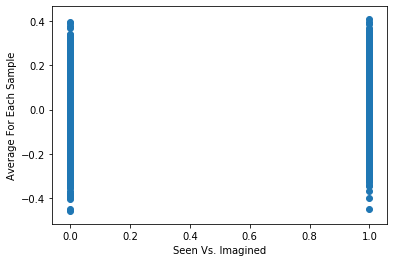

In [5]:
absavgdata = np.average(X.reshape(X.shape[0],-1),axis = 1)
plt.scatter(y,absavgdata)
plt.xlabel('Seen Vs. Imagined')
plt.ylabel('Average For Each Sample')
plt.show()